# Feature Selection
This notebook will include feature selection part for the dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
import warnings
import json
import pickle
warnings.filterwarnings('ignore')

In [2]:
modified = "../../data/modified/"

In [3]:
OneHotFile = modified + "OneHotDerived2.pkl"
OneHotData = pickle.load(open(OneHotFile, "rb"))

In [4]:
df_train_oneHot = OneHotData["train"]
df_test_oneHot = OneHotData["test"]

In [5]:
corr = df_train_oneHot.corr()["SalePrice"]
corr = corr[np.argsort(np.abs(corr), axis=0)[::-1]]
corr.drop("SalePrice", inplace=True)

In [6]:
def plot_corr(corr):
    corr_display = pd.DataFrame()
    corr_display["feature"] = pd.Series(corr.index)
    corr_display["Correlations"] = pd.Series(corr.values)
    plt.figure(figsize = (6, 0.25*len(corr.index)))
    sns.barplot(data=corr_display, y="feature", x="Correlations", orient="h")

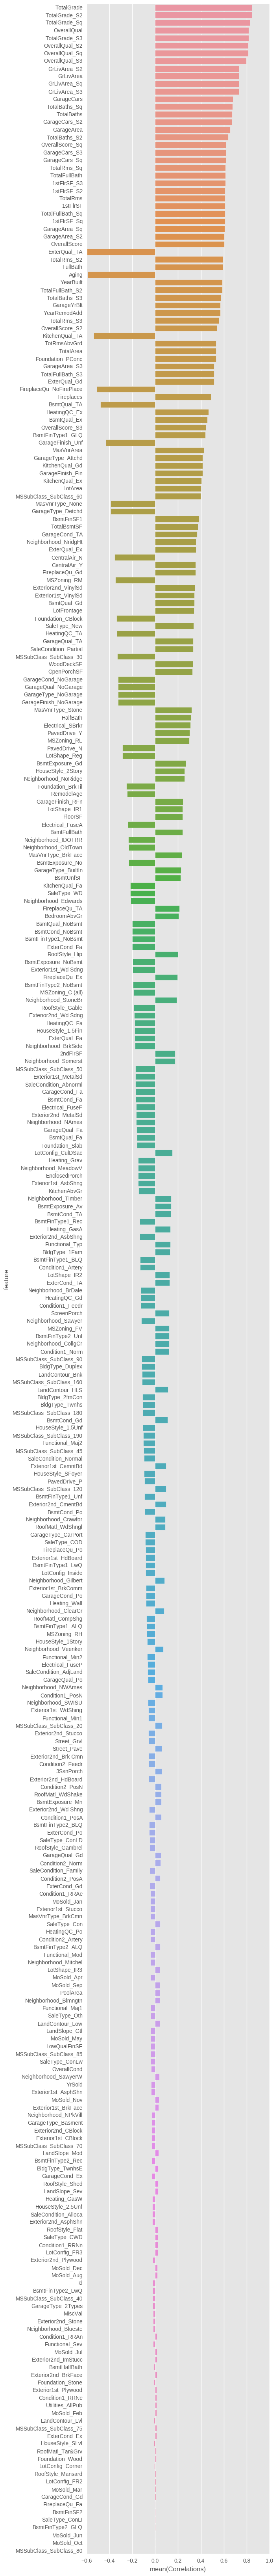

In [7]:
plot_corr(corr)

In [8]:
df_train_oneHot.drop("Id", axis=1, inplace=True)
target = df_train_oneHot["SalePrice"]
df_train_oneHot.drop("SalePrice", axis=1, inplace=True)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

scorer = make_scorer(mean_squared_error, False)
def rmse_cv(model, X, y):
    return (cross_val_score(model, X, y, scoring=scorer)).mean()

In [10]:
Id = df_test_oneHot["Id"]
df_test_oneHot.drop("Id", axis=1, inplace=True)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train_oneHot)
df_train_oneHot.loc[:,:] = scaler.transform(df_train_oneHot)
df_test_oneHot.loc[:,:] = scaler.transform(df_test_oneHot)

## Lasso feature selection
[Lasso](http://scikit-learn.org/stable/modules/linear_model.html#lasso) is a linear model that yields sparse models, therefore it can be used to do the feature selection.

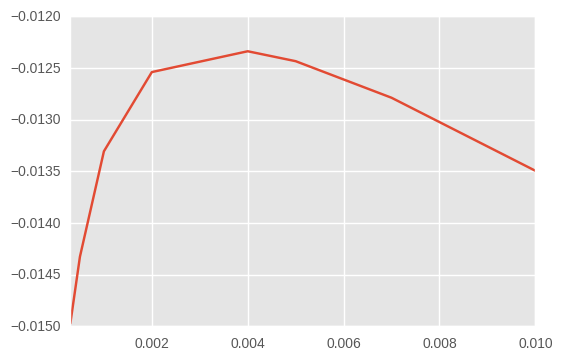

In [12]:
from sklearn.linear_model import Lasso
alphas =[3e-4, 5e-4, 1e-3,2e-3,4e-3,5e-3,7e-3, 1e-2]
cv_lasso = [rmse_cv(Lasso(alpha=alpha, max_iter=50000), df_train_oneHot, target) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [13]:
model = Lasso(alpha = 4e-3, max_iter = 50000).fit(df_train_oneHot, target)

In [14]:
selected = df_train_oneHot.columns.values[model.coef_ > 0]

In [15]:
selected = list(selected)
print(selected)

['LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch', 'PoolArea', 'MSZoning_FV', 'Street_Pave', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Exterior1st_MetalSd', 'MasVnrType_Stone', 'ExterCond_TA', 'Foundation_PConc', 'Foundation_Stone', 'BsmtQual_Ex', 'BsmtExposure_Gd', 'BsmtFinType1_GLQ', 'BsmtFinType2_ALQ', 'Heating_GasW', 'HeatingQC_Ex', 'CentralAir_Y', 'KitchenQual_Ex', 'Functional_Typ', 'FireplaceQu_Gd', 'PavedDrive_Y', 'MoSold_May', 'SaleType_ConLD', 'SaleType_New', 'TotalArea', 'TotalGrade_S3', 'GrLivArea_S3', 'GarageCars_S3', 'GarageCars_Sq', 'TotalBaths_S3', 'TotalBaths_Sq', 'GarageArea_Sq', 'TotalFullBath_S3', '1stFlrSF_Sq', 'OverallScore_Sq']


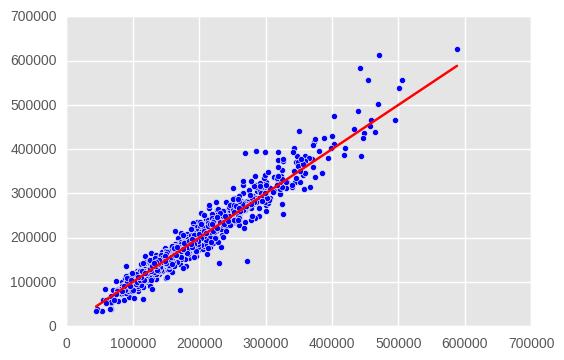

In [16]:
p_pred = np.expm1(model.predict(df_train_oneHot))
plt.scatter(p_pred, np.expm1(target))
plt.plot([min(p_pred), max(p_pred)], [min(p_pred), max(p_pred)], c= "red")

In [17]:
p = np.expm1(model.predict(df_test_oneHot))
solution = pd.DataFrame({"id":Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../../data/submission/OneHotDerived2-Lasso.csv", index = False)

In [18]:
train_X = df_train_oneHot[selected]
test_X = df_test_oneHot[selected]
OneHot_Lasso = modified + "OneHotDerived2_Lasso.pkl"
OneHot = {"train_X": train_X, "test_X": test_X, "y": target, "id": Id}
with open(OneHot_Lasso, 'wb') as f:
    pickle.dump(OneHot, f , pickle.HIGHEST_PROTOCOL)

## Randomized Lasso
Randomized Lasso is a stability selection that can be used for feature selection.

In [19]:
from sklearn.linear_model import RandomizedLasso
rlasso = RandomizedLasso(alpha=alphas, random_state=25)
rlasso.fit(df_train_oneHot, target)

RandomizedLasso(alpha=[0.0003, 0.0005, 0.001, 0.002, 0.004, 0.005, 0.007, 0.01],
        eps=2.2204460492503131e-16, fit_intercept=True, max_iter=500,
        memory=Memory(cachedir=None), n_jobs=1, n_resampling=200,
        normalize=True, pre_dispatch='3*n_jobs', precompute='auto',
        random_state=25, sample_fraction=0.75, scaling=0.5,
        selection_threshold=0.25, verbose=False)

In [20]:
feature_display = pd.DataFrame()
feature_display["Features"] = pd.Series(list(df_train_oneHot.columns.values))
feature_display["Score"] = pd.Series(rlasso.scores_)

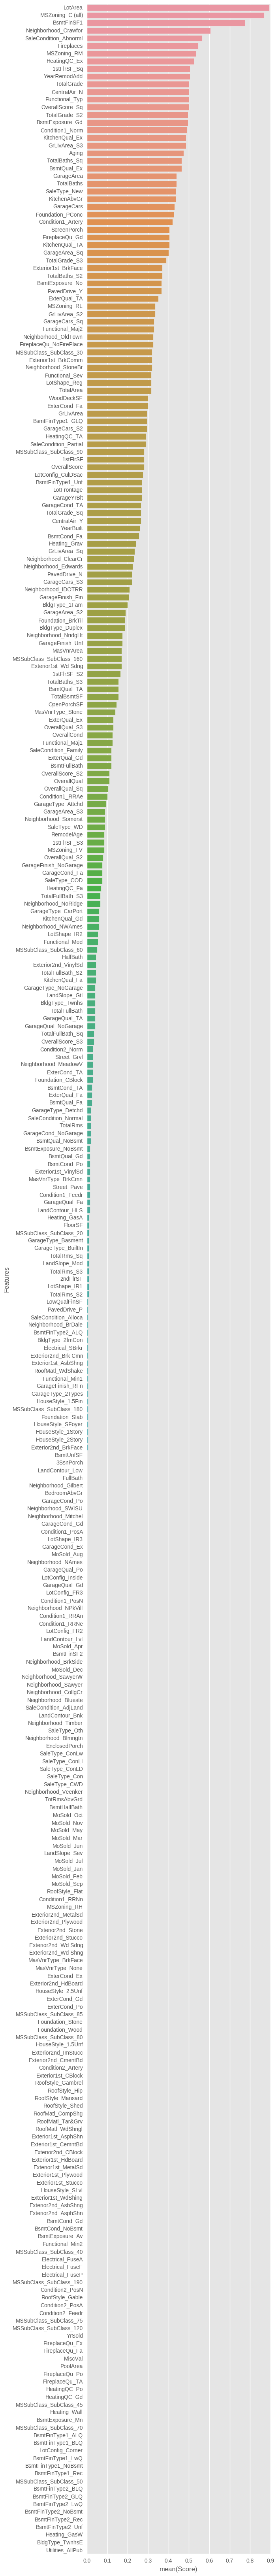

In [21]:
feature_display = feature_display.sort_values(by= "Score", ascending=False)
plt.figure(figsize = (6, 0.25*len(list(df_train_oneHot.columns.values))))
sns.barplot(data=feature_display, y="Features", x="Score", orient="h")

In [22]:
selected = feature_display["Features"][:55]

In [23]:
train_X = df_train_oneHot[selected]
test_X = df_test_oneHot[selected]
OneHot_Lasso = modified + "OneHotDerived2_RLasso.pkl"
OneHot = {"train_X": train_X, "test_X": test_X, "y": target, "id": Id}
with open(OneHot_Lasso, 'wb') as f:
    pickle.dump(OneHot, f , pickle.HIGHEST_PROTOCOL)

Similar to the Baysian mean method data.

In [24]:
BayesianFile = modified + "BayesianDerived2.pkl"
BayesianData = pickle.load(open(BayesianFile, "rb"))

In [25]:
df_train_Bayesian = BayesianData["train"]
df_test_Bayesian = BayesianData["test"]

In [26]:
df_train_Bayesian.drop("Id", axis=1, inplace=True)
target = df_train_Bayesian["SalePrice"]
df_train_Bayesian.drop("SalePrice", axis=1, inplace=True)

In [27]:
Id = df_test_Bayesian["Id"]
df_test_Bayesian.drop("Id", axis=1, inplace=True)

In [28]:
scaler = StandardScaler().fit(df_train_Bayesian)
df_train_Bayesian.loc[:,:] = scaler.transform(df_train_Bayesian)
df_test_Bayesian.loc[:,:] = scaler.transform(df_test_Bayesian)

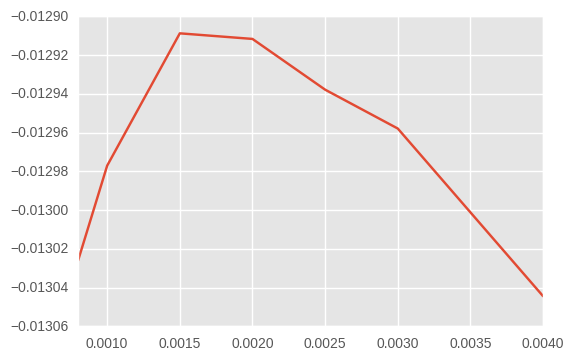

In [29]:
alphas =[8e-4, 1e-3,1.5e-3,2e-3,2.5e-3, 3e-3,4e-3]
cv_lasso = [rmse_cv(Lasso(alpha=alpha, max_iter=50000), df_train_Bayesian, target) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [30]:
model = Lasso(alpha = 1.5e-3, max_iter =  50000).fit(df_train_Bayesian, target)

In [31]:
selected = df_train_Bayesian.columns.values[model.coef_ > 0]

In [32]:
selected = list(selected)
print(selected)

['MSSubClass_num_pred', 'MSZoning_num_pred', 'Street_num_pred', 'LandContour_num_pred', 'LotConfig_num_pred', 'Condition1_num_pred', 'BldgType_num_pred', 'Exterior1st_num_pred', 'MasVnrType_num_pred', 'ExterCond_num_pred', 'Foundation_num_pred', 'BsmtCond_num_pred', 'BsmtExposure_num_pred', 'Heating_num_pred', 'HeatingQC_num_pred', 'CentralAir_num_pred', 'Functional_num_pred', 'FireplaceQu_num_pred', 'GarageFinish_num_pred', 'GarageQual_num_pred', 'GarageCond_num_pred', 'PavedDrive_num_pred', 'SaleCondition_num_pred', 'LotArea', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', 'BsmtFullBath', 'HalfBath', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'OverallScore', 'FireplaceGrade', 'TotalGrade_S3', 'OverallQual_Sq', 'Neighborhood_num_pred_S3', 'GrLivArea_S3', 'GrLivArea_Sq', 'GarageCars_S3', 'GarageCars_Sq', 'ExterQual_num_pred_S3', 'TotalBaths_S3', 'TotalBaths_Sq', 'BsmtQual_num_pre

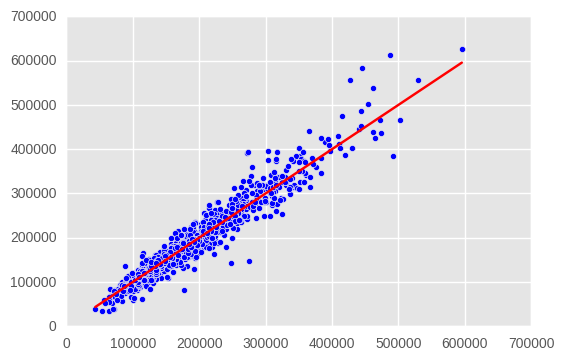

In [33]:
p_pred = np.expm1(model.predict(df_train_Bayesian))
plt.scatter(p_pred, np.expm1(target))
plt.plot([min(p_pred), max(p_pred)], [min(p_pred), max(p_pred)], c= "red")

In [34]:
p = np.expm1(model.predict(df_test_Bayesian))
solution = pd.DataFrame({"id":Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../../data/submission/BayesianDerived2-Lasso.csv", index = False)

In [35]:
train_X = df_train_Bayesian[selected]
test_X = df_test_Bayesian[selected]
Bayesian_Lasso = modified + "BayesianDerived2_Lasso.pkl"
Bayesian = {"train_X": train_X, "test_X": test_X, "y": target, "id": Id}
with open(Bayesian_Lasso, 'wb') as f:
    pickle.dump(Bayesian, f , pickle.HIGHEST_PROTOCOL)

In [36]:
rlasso = RandomizedLasso(alpha=alphas, random_state=25)
rlasso.fit(df_train_Bayesian, target)

RandomizedLasso(alpha=[0.0008, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.004],
        eps=2.2204460492503131e-16, fit_intercept=True, max_iter=500,
        memory=Memory(cachedir=None), n_jobs=1, n_resampling=200,
        normalize=True, pre_dispatch='3*n_jobs', precompute='auto',
        random_state=25, sample_fraction=0.75, scaling=0.5,
        selection_threshold=0.25, verbose=False)

In [37]:
feature_display = pd.DataFrame()
feature_display["Features"] = pd.Series(list(df_train_Bayesian.columns.values))
feature_display["Score"] = pd.Series(rlasso.scores_)

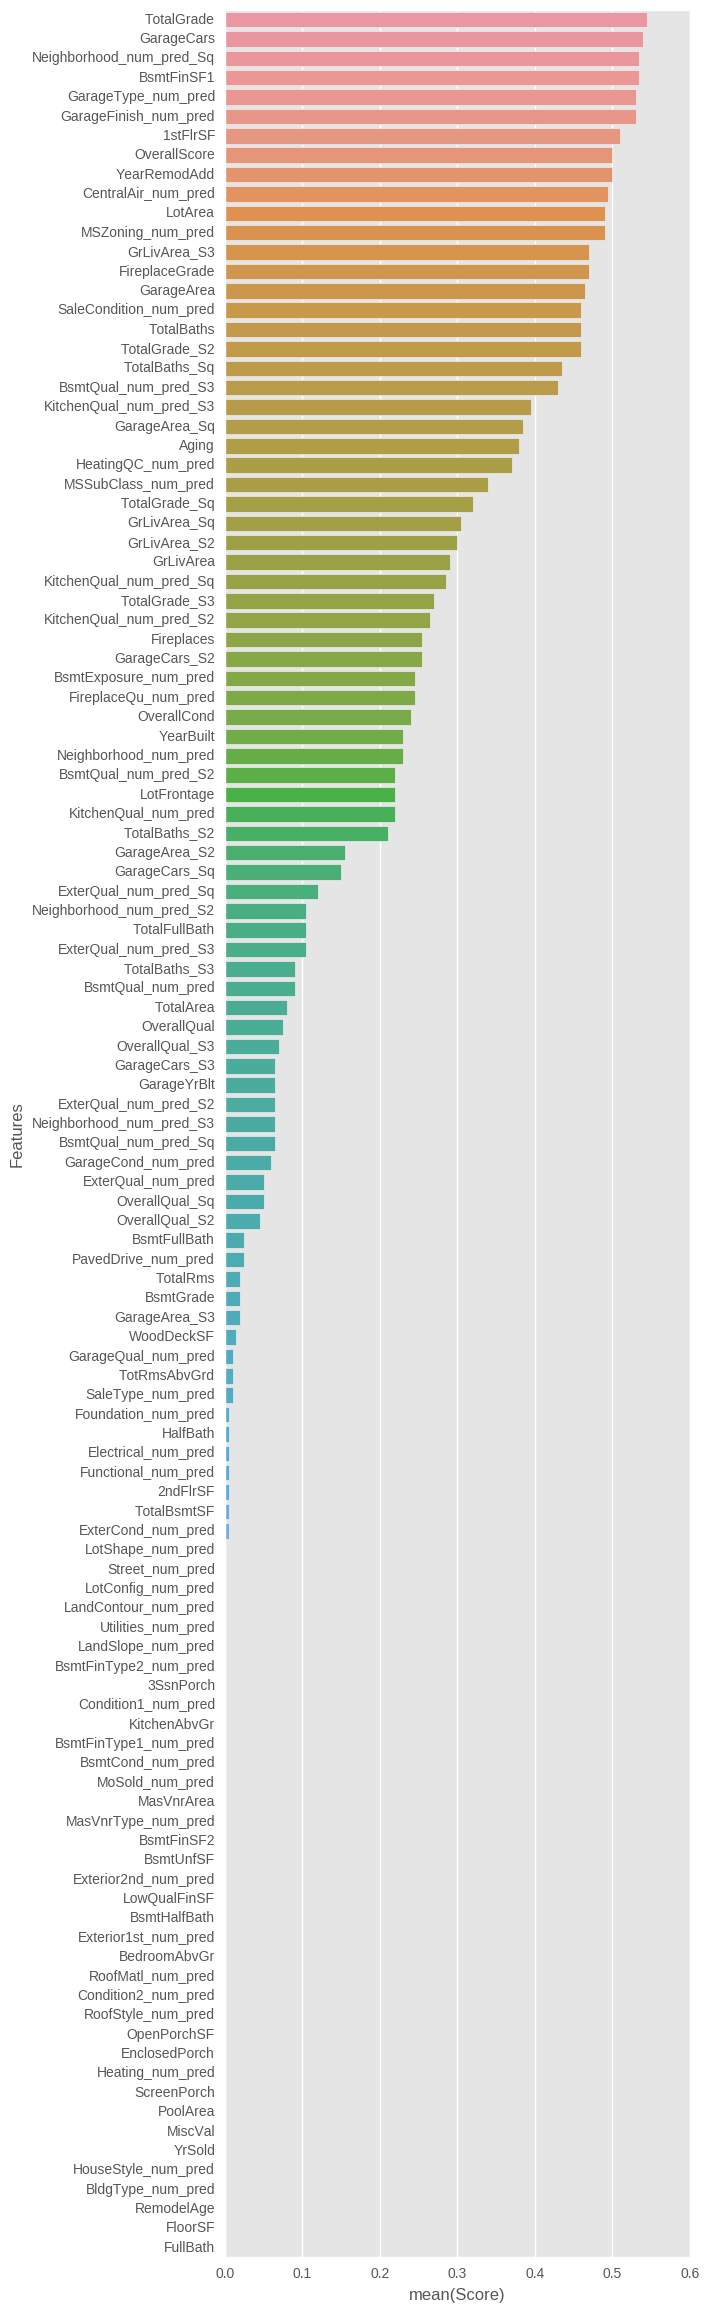

In [38]:
feature_display = feature_display.sort_values(by= "Score", ascending=False)
plt.figure(figsize = (6, 0.25*len(list(df_train_Bayesian.columns.values))))
sns.barplot(data=feature_display, y="Features", x="Score", orient="h")

In [39]:
selected = feature_display["Features"][:55]

In [40]:
train_X = df_train_Bayesian[selected]
test_X = df_test_Bayesian[selected]
Bayesian_Lasso = modified + "BayesianDerived2_RLasso.pkl"
Bayesian = {"train_X": train_X, "test_X": test_X, "y": target, "id": Id}
with open(Bayesian_Lasso, 'wb') as f:
    pickle.dump(Bayesian, f , pickle.HIGHEST_PROTOCOL)